In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# the switching binomial generative model


In [2]:
t_titre = 35
t_label = 25
fig_width= 15
N_scan = 100
#N_scan = 10 # DEBUG

In [3]:
observer = 'AM'
mode = 'pari'
ext = '.png'
dpi = 400
from aSPEM import Analysis
e = Analysis(observer=observer, mode=mode)

# the online BCP model: figures for the model

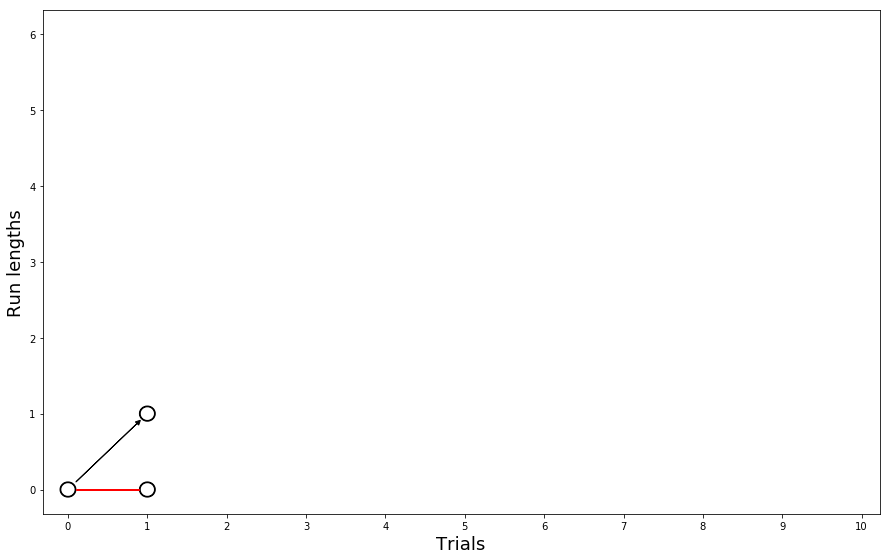

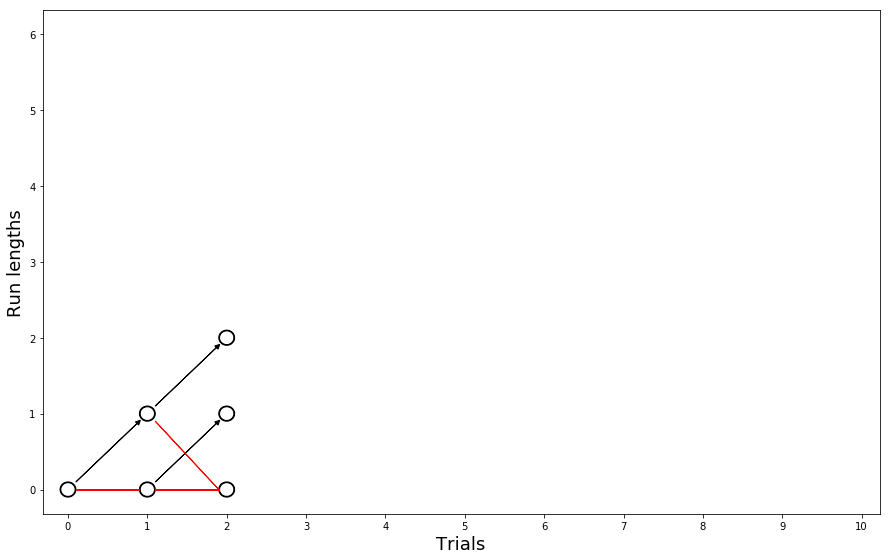

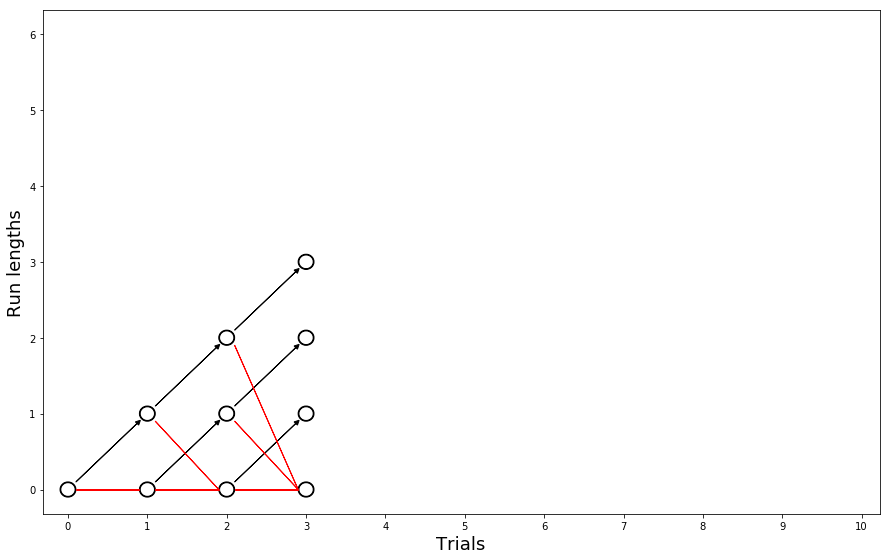

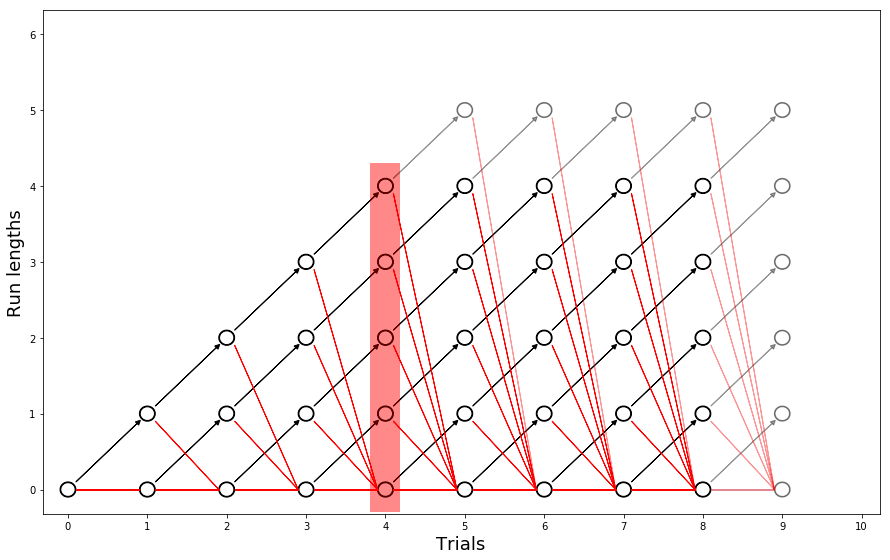

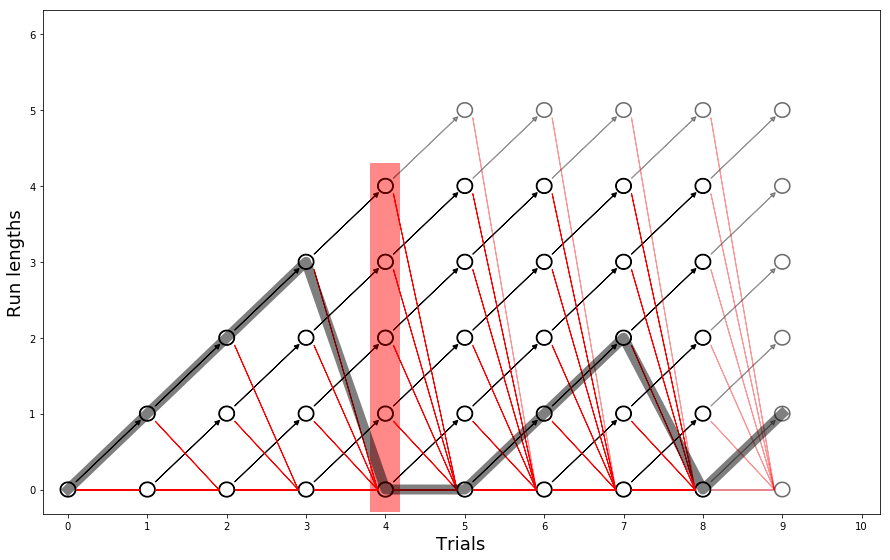

In [4]:
fig_width = 15
r_cir = 0.1
s_arrow = 0.06
alpha = .4

c_f1 = 'k'
c_f2 = 'r'
c_cir = 'k'
labelsize = 18

layer = 4

NUM = 6


from matplotlib.patches import Circle, Wedge
from matplotlib.collections import PatchCollection


def arrow_1(ax, x, y, alpha=None):
    if alpha is None:
        plt.arrow(x+r_cir, y+r_cir, 1-(r_cir*2)-(s_arrow/2), 1-(r_cir*2)-(s_arrow/2),
                  head_width=s_arrow, head_length=s_arrow, fc=c_f1, ec=c_f1)
    else:
        plt.arrow(x+r_cir, y+r_cir, 1-(r_cir*2)-(s_arrow/2), 1-(r_cir*2)-(s_arrow/2),
                  head_width=s_arrow, head_length=s_arrow, fc=c_f1, ec=c_f1, alpha=alpha)


def arrow_2(ax, x, y, alpha=None):
    if alpha is None:
        if y == 0:
            plt.arrow(x+r_cir, y, 1-(r_cir*2), -y,
                      head_width=0., head_length=0., ec=c_f2)
        else:
            plt.arrow(x+r_cir, y-r_cir, 1-(r_cir*2), -y+r_cir,
                      head_width=0., head_length=0., ec=c_f2)
    else:
        if y == 0:
            plt.arrow(x+r_cir, y, 1-(r_cir*2), -y,
                      head_width=0., head_length=0., ec=c_f2, alpha=alpha)
        else:
            plt.arrow(x+r_cir, y-r_cir, 1-(r_cir*2), -y+r_cir,
                      head_width=0., head_length=0., ec=c_f2, alpha=alpha)


for layer in range(1, 6):
    num = NUM

    if layer == 1:
        num = 2
    if layer == 2:
        num = 3
    if layer == 3:
        num = 4

    fig, ax = plt.subplots(1, 1, figsize=(
        fig_width, fig_width/1.6180), sharex=True)

    patches = []
    patches2 = []

    if layer < 4:
        ploup = range(num)
    else:
        ploup = range(int(num*1.6180)+1)

    for x in ploup:
        if x < num:
            lala = range(x+1)
            lalay = num-1
        else:
            lala = range(num)
            lalay = lala[-1]
        for y in lala:
            if num > 4:
                if y < lalay and x < int(num*1.6180):
                    patches += [Wedge((x, y), r_cir, 0, 360, width=r_cir/10)]
                else:
                    patches2 += [Wedge((x, y), r_cir, 0, 360, width=r_cir/10)]

                if x < int(num*1.6180):
                    if y <= lalay-1:
                        if y != lalay-1 and x < int(num*1.6180)-1:
                            arrow_1(ax, x, y)
                        else:
                            arrow_1(ax, x, y, alpha=alpha)

                        if x < int(num*1.6180)-1:
                            arrow_2(ax, x, y)
                        else:
                            arrow_2(ax, x, y, alpha=alpha)

                    else:
                        arrow_2(ax, x, y, alpha=alpha)
                plt.vlines(4, -0.3, 4.3, color='r', lw=30, alpha=0.01)
            else:
                patches += [Wedge((x, y), r_cir, 0, 360, width=r_cir/10)]
                if y <= lalay-1 and x <= lalay-1:
                    arrow_1(ax, x, y)
                    arrow_2(ax, x, y)

    p = PatchCollection(patches, color=c_cir, lw=1)
    ax.add_collection(p)
    p = PatchCollection(patches2, color=c_cir, alpha=alpha, lw=1)
    ax.add_collection(p)

    plt.tick_params(bottom=True, top=False, right=False, left=True)
    plt.ylabel('Run lengths', fontsize=labelsize)
    plt.xlabel('Trials', fontsize=labelsize)
    plt.xticks(np.arange((NUM+0.32)*1.6180))

    if layer > 4:
        plt.plot([0, 1, 2, 3, 0, 0, 1, 2, 0, 1], lw=10, alpha=alpha+0.1, c='k')

    plt.axis([-0.32, (NUM+0.32)*1.6180, -0.32, NUM+0.32])
    plt.savefig('figures/bcp_model_layer_%s%s' % (layer, ext))

    plt.show()

# evaluating the best hazard rate using a likelihood score

Vérifier tau !

Block 2


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


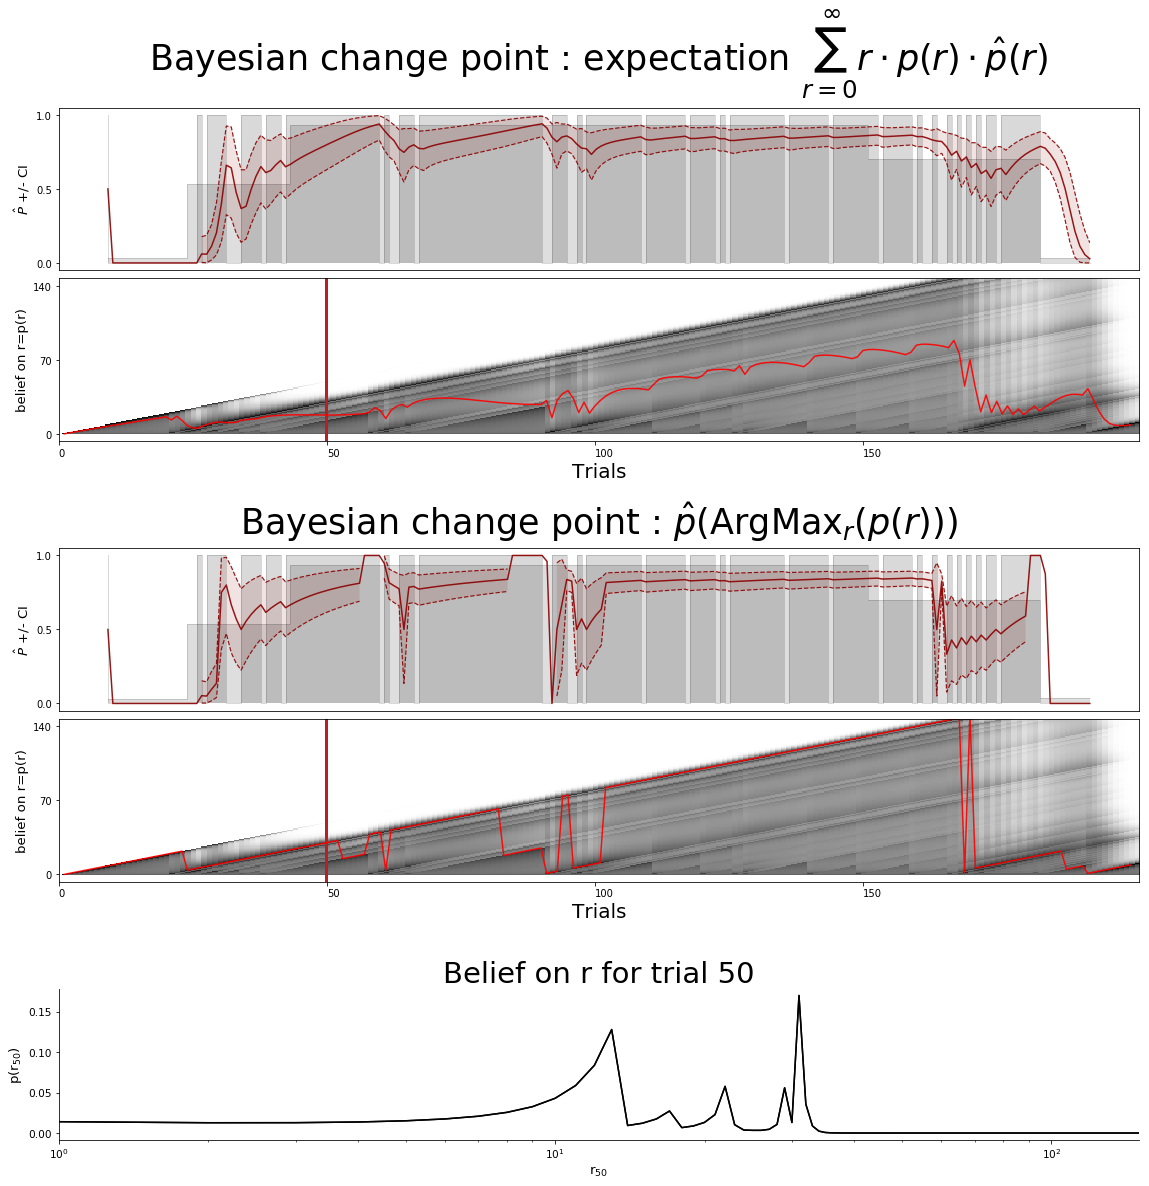

In [5]:
fig, axs = e.plot_bcp(plot='detail', block=2, trial=50)
fig.savefig('figures/BCP_readouts' + ext, dpi=dpi)

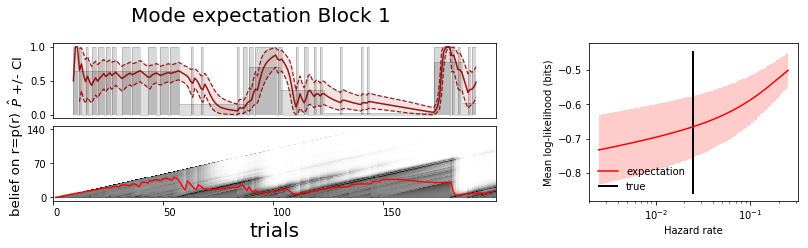

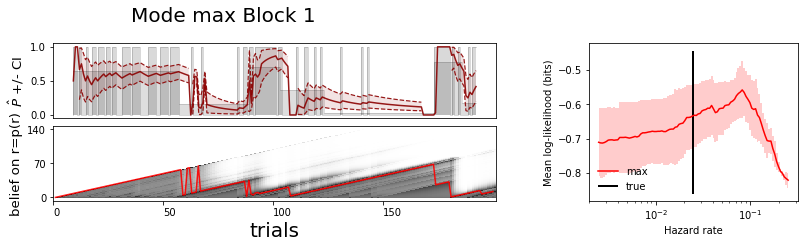

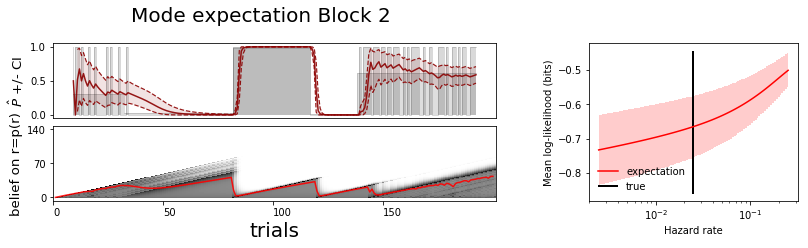

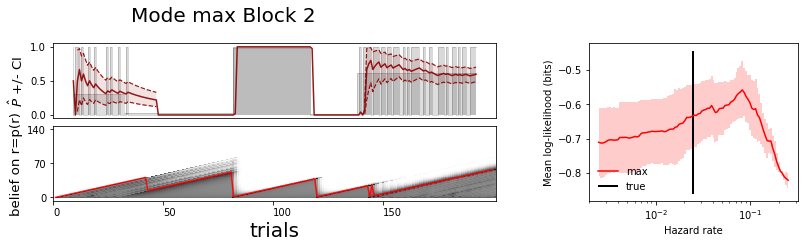

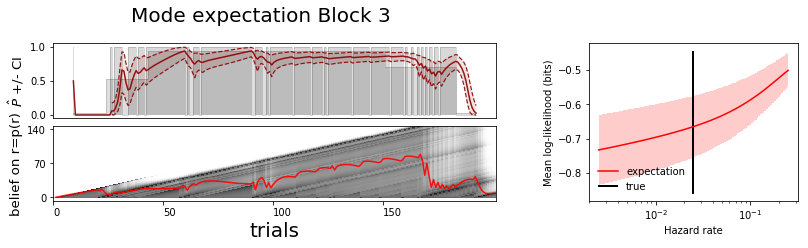

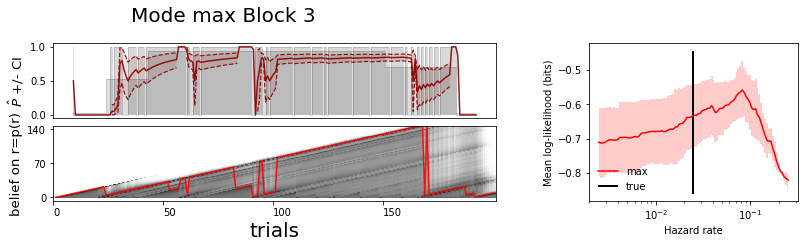

In [6]:
fig, axs = e.plot_bcp(N_scan=N_scan)
fig.savefig('figures/BCP_scan' + ext, dpi=dpi)

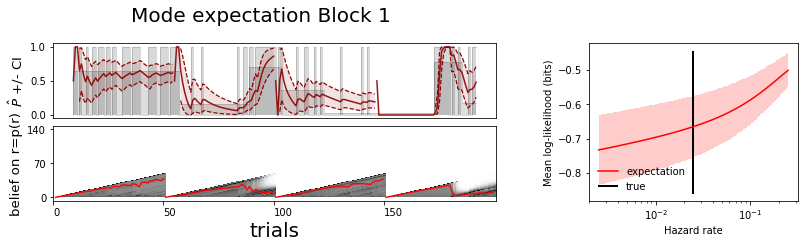

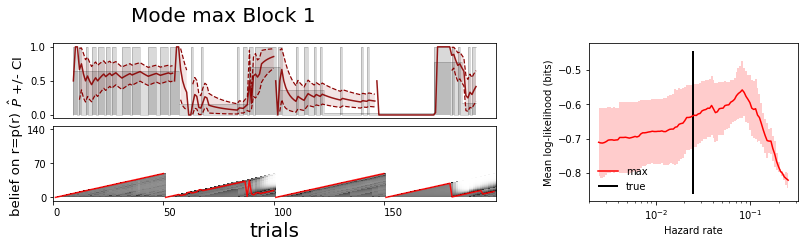

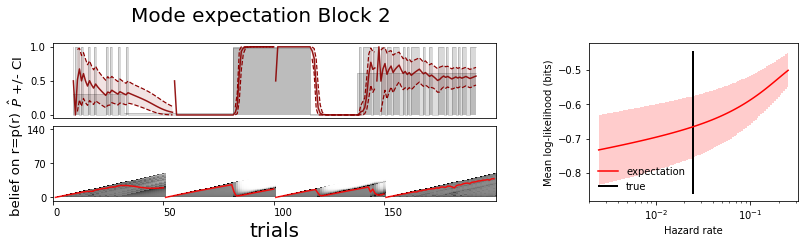

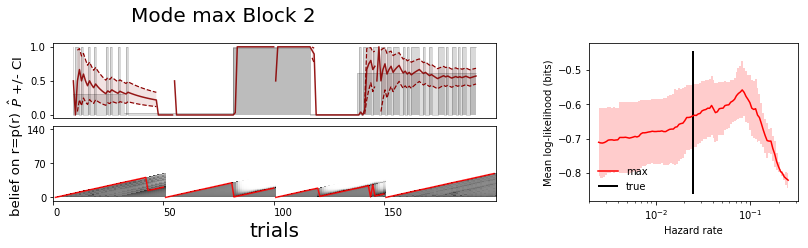

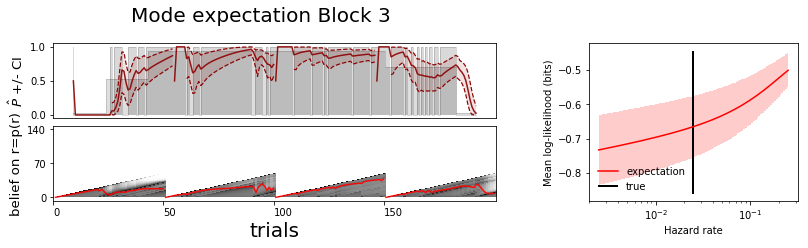

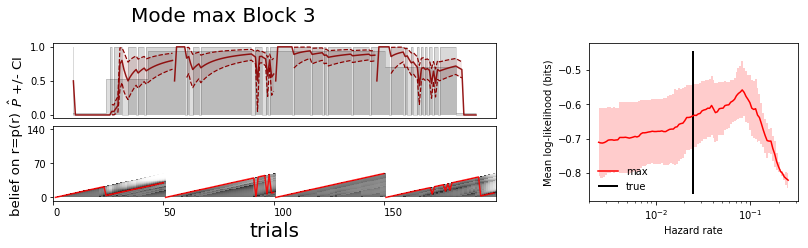

In [7]:
fig, axs = e.plot_bcp(N_scan=N_scan, pause=True)
#fig.savefig('figures/BCP_scan' + ext, dpi=dpi)

plot pout chaque r la distriubtion Beta correspondant à $P(p |r) = B(p; p(r)*r, (1-p(r))*r)$